# Import Library

In [ ]:
# Import Libraries
import os
import pandas as pd
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Visuzliation Setting
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
from matplotlib import colors
import seaborn as sns

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root = os.path.join(os.getcwd(), '/content/drive/MyDrive/BigContest/DATA')

# Training Data
빅콘테스트 제공 데이터 전처리

## Import Data

In [ ]:
df_raw = pd.read_excel(os.path.join(root, 'train.xlsx'))
df_train = df_raw.copy()

### Add Columns

In [ ]:
# 날짜변수 추가
df_train['year'] = df_train['REG_DATE'].dt.year
df_train['month'] = df_train['REG_DATE'].dt.month
df_train['day'] = df_train['REG_DATE'].dt.day

In [ ]:
df_train['VALUE_COUNT'] = 0;
value_dict = {}
for name, value in zip(df_train['P_NAME'].value_counts().index,df_train['P_NAME'].value_counts()):
    value_dict[name] = value

def value(col):
    return value_dict[col]

df_train['VALUE_COUNT'] = df_train['P_NAME'].apply(value)

### One hot encoding
P_IMPORT_TYPE 이라는 특수한 컬럼에 대한 전처리

In [ ]:
import_type_list = set()
for tmp in df_train.P_IMPORT_TYPE.unique():
    for a in tmp.split(','):
        import_type_list.add(a)

In [ ]:
for name in import_type_list:
    df_train[name] = 0
    df_train.loc[df_train['P_IMPORT_TYPE'].str.contains(name, regex=False), name] = 1

---

# Weather data

## Import Data

In [ ]:
df_weather_code = pd.read_excel(os.path.join(root, 'raw_weather_code.xlsx'), header=None, index_col=0)

In [ ]:
weather_list = [pd.read_csv(os.path.join(root, 'raw_weather_20151228_20161227.csv'), encoding='euc-kr') , 
                pd.read_csv(os.path.join(root, 'raw_weather_20161228_20171227.csv'), encoding='euc-kr') , 
                pd.read_csv(os.path.join(root, 'raw_weather_20171228_20181227.csv'), encoding='euc-kr') , 
                pd.read_csv(os.path.join(root, 'raw_weather_20181228_20191227.csv'), encoding='euc-kr') , 
                pd.read_csv(os.path.join(root, 'raw_weather_20191228_20201227.csv'), encoding='euc-kr') , 
                pd.read_csv(os.path.join(root, 'raw_weather_20201228_20210818.csv'), encoding='euc-kr')]


## Preprocess
- '지점'에 따른 나라명 컬럼 (country) 추가
- 각 나라, 일자 별로 평균 강수량, 풍속, 기온 계산

In [ ]:
# 지점에 따라 나라명 추가
def set_country(row):
    data = df_weather_code[df_weather_code[1] == row['지점']]
    if data.empty:
        return ""
    return data.iloc[0][2]


def preprocess_weather(df_weather):
    # 날짜 정보 정리
    df_weather['year'] = df_weather['일시'].astype('str').str[:4].astype('int')
    df_weather['month'] = df_weather['일시'].astype('str').str[5:7].astype('int')
    df_weather['day'] = df_weather['일시'].astype('str').str[8:10].astype('int')
    # 1차 평균
    df_weather['rain'] = df_weather[['지점', 'year', 'month', 'day', '강수량']].groupby(['지점', 'year', 'month', 'day']).transform('mean')
    df_weather['wind'] = df_weather[['지점', 'year', 'month', 'day', '풍속']].groupby(['지점', 'year', 'month', 'day']).transform('mean')
    df_weather['temperature'] = df_weather[['지점', 'year', 'month', 'day', '기온']].groupby(['지점', 'year', 'month', 'day']).transform('mean')
    # 컬럼/행 정리
    df_weather.drop(columns = ['지점명', '일시', '강수량', '풍속', '기온'], inplace=True)
    df_weather.drop_duplicates(inplace=True)
    # 나라명 추가
    df_weather['CTRY_1'] = ""
    for i, row in df_weather.iterrows():
        df_weather.at[i, 'CTRY_1'] = set_country(row)
    # 2차 평균
    df_weather['rain'] = df_weather[['CTRY_1', 'year', 'month', 'day', 'rain']].groupby(['CTRY_1', 'year', 'month', 'day']).transform('mean')
    df_weather['wind'] = df_weather[['CTRY_1', 'year', 'month', 'day', 'wind']].groupby(['CTRY_1', 'year', 'month', 'day']).transform('mean')
    df_weather['temperature'] = df_weather[['CTRY_1', 'year', 'month', 'day', 'temperature']].groupby(['CTRY_1', 'year', 'month', 'day']).transform('mean')
    # 컬럼/행 정리
    df_weather.drop(columns = ['지점'], inplace=True)
    df_weather.drop_duplicates(inplace=True)
    # 인덱스 정리
    df_weather.reset_index(drop=True, inplace=True)

In [ ]:
for df in weather_list:
    preprocess_weather(df)
df_weather = pd.concat(weather_list)

In [ ]:
df_weather = pd.concat(weather_list)

In [ ]:
df_weather.describe()

#### 확인필요
- outlier 찾아내기 > 값이 너무 크거나 작은 경우 제외
- 날짜별로 확인 후 비어있는 값 채워넣기 (전/다음날 이용)
    - 13947개 데이터 중 rain, wind, temperature 갯수 보면 몇개 비어있는지 확인 가능
- 합치기..
- 강수량의 경우 NaN 값이 너무 많음
    - 위 전처리들을 한 후에도 많다면 사용불가
    - 위 전처리 후에는 적다면 전날/다음날 데이터 기반으로 채워넣기 진행

## Version 2

### Import Data

In [ ]:
rwt_20152016 = pd.read_csv('/content/drive/MyDrive/빅콘/Seafood_Import_Price_Prediction/DATA/weather/raw_weather_20151228_20161227.csv',encoding='cp949') 
rwt_20162017 = pd.read_csv('/content/drive/MyDrive/빅콘/Seafood_Import_Price_Prediction/DATA/weather/raw_weather_20161228_20171227.csv',encoding='cp949') 
rwt_20172018 = pd.read_csv('/content/drive/MyDrive/빅콘/Seafood_Import_Price_Prediction/DATA/weather/raw_weather_20171228_20181227.csv',encoding='cp949') 
rwt_20182019 = pd.read_csv('/content/drive/MyDrive/빅콘/Seafood_Import_Price_Prediction/DATA/weather/raw_weather_20181228_20191227.csv',encoding='cp949') 
rwt_20192020 = pd.read_csv('/content/drive/MyDrive/빅콘/Seafood_Import_Price_Prediction/DATA/weather/raw_weather_20191228_20201227.csv',encoding='cp949') 
rwt_20202021 = pd.read_csv('/content/drive/MyDrive/빅콘/Seafood_Import_Price_Prediction/DATA/weather/raw_weather_20201228_20210818.csv',encoding='cp949') 

### Merge

In [ ]:
rwt = pd.merge(rwt_20152016,rwt_20162017,how='outer')

rwt = rwt.append(rwt_20172018)
rwt = rwt.append(rwt_20182019)
rwt = rwt.append(rwt_20192020)
rwt = rwt.append(rwt_20202021)

rwt # 국가별 강수량,풍속,기온 데이터

### 국가별로 나누기

#### 노르웨이 Weather

In [324]:
rwt_nor = pd.DataFrame()

for i in [1373, 1007, 1233, 1114, 1098, 1002, 1317, 1152, 1028, 1008, 1415, 1001, 1212, 1492, 1384, 1241, 1403, 1065, 1196, 1271, 1026 ,1025,1465, 1238]:
    rwt_nor = rwt_nor.append(rwt[rwt['지점']==i]) # 노르웨이

rwt_nor = rwt_nor.sort_values(by=['지점','일시'])

rwt_nor['일시'] = rwt_nor['일시'].str[:10] # 시간 부분 삭제

rwt_nor['일시'] = rwt_nor['일시'].astype('datetime64')

rwt_nor = rwt_nor.query('일시.dt.dayofweek == 0') # 일시를 일주일 간격으로 변환

rwt_nor['국가'] = '노르웨이'

rwt_nor

,지점,지점명,일시,풍속,강수량,기온,국가
0,1001,얀마이엔,2015-12-28,11.0,NaN,2.3,노르웨이
1,1001,얀마이엔,2015-12-28,13.0,0.0,2.6,노르웨이
2,1001,얀마이엔,2015-12-28,11.0,NaN,3.3,노르웨이
3,1001,얀마이엔,2015-12-28,13.0,0.1,3.4,노르웨이
4,1001,얀마이엔,2015-12-28,15.0,NaN,3.7,노르웨이
...,...,...,...,...,...,...,...
25067,1492,오슬로-블린데른,2020-06-01,3.0,NaN,12.8,노르웨이
25068,1492,오슬로-블린데른,2020-06-01,1.0,NaN,18.1,노르웨이
25069,1492,오슬로-블린데른,2020-06-01,2.0,NaN,22.9,노르웨이
25070,1492,오슬로-블린데른,2020-06-01,3.0,NaN,24.0,노르웨이


##### Preprocessing

In [325]:
rwt_nor['강수량'].isna().sum()

32300

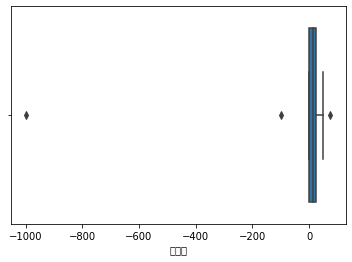

In [326]:
sns.boxplot(x = rwt_nor['강수량'].unique())
plt.xlabel('강수량')
plt.show()
# 이상치 제거 필요

In [327]:
rwt_nor[rwt_nor['강수량']<0]

,지점,지점명,일시,풍속,강수량,기온,국가
110,1001,얀마이엔,2016-01-11,8.0,-999.0,-5.7,노르웨이
390,1001,얀마이엔,2016-02-15,2.0,-99.8,-7.6,노르웨이
392,1001,얀마이엔,2016-02-15,1.0,-99.8,-6.3,노르웨이
394,1001,얀마이엔,2016-02-15,8.0,-99.8,-3.0,노르웨이
396,1001,얀마이엔,2016-02-15,3.0,-99.8,-0.8,노르웨이
...,...,...,...,...,...,...,...
61334,1492,오슬로-블린데른,2019-10-28,2.0,-999.0,7.3,노르웨이
61335,1492,오슬로-블린데른,2019-10-28,1.0,-99.8,5.6,노르웨이
24435,1492,오슬로-블린데른,2020-03-02,4.0,-99.8,3.9,노르웨이
24436,1492,오슬로-블린데른,2020-03-02,5.0,-99.8,4.4,노르웨이


In [328]:
rwt_nor = rwt_nor[(rwt_nor['강수량']>=0) | (rwt_nor['강수량'].isna())] # 강수량 음수 제거

rwt_nor

,지점,지점명,일시,풍속,강수량,기온,국가
0,1001,얀마이엔,2015-12-28,11.0,NaN,2.3,노르웨이
1,1001,얀마이엔,2015-12-28,13.0,0.0,2.6,노르웨이
2,1001,얀마이엔,2015-12-28,11.0,NaN,3.3,노르웨이
3,1001,얀마이엔,2015-12-28,13.0,0.1,3.4,노르웨이
4,1001,얀마이엔,2015-12-28,15.0,NaN,3.7,노르웨이
...,...,...,...,...,...,...,...
25067,1492,오슬로-블린데른,2020-06-01,3.0,NaN,12.8,노르웨이
25068,1492,오슬로-블린데른,2020-06-01,1.0,NaN,18.1,노르웨이
25069,1492,오슬로-블린데른,2020-06-01,2.0,NaN,22.9,노르웨이
25070,1492,오슬로-블린데른,2020-06-01,3.0,NaN,24.0,노르웨이


In [329]:
rwt_nor['풍속'].isna().sum()

327

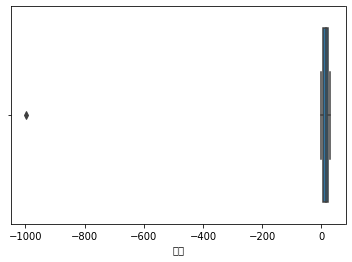

In [330]:
sns.boxplot(x = rwt_nor['풍속'].unique())
plt.xlabel('풍속')
plt.show()
# 이상치 제거 필요

In [331]:
rwt_nor[rwt_nor['풍속']<0]

,지점,지점명,일시,풍속,강수량,기온,국가
872,1001,얀마이엔,2018-04-16,-998.0,0.1,1.6,노르웨이
18969,1065,카라스요크,2018-01-29,-998.0,0.3,-19.0,노르웨이


In [332]:
rwt_nor = rwt_nor[(rwt_nor['풍속']>=0) | (rwt_nor['풍속'].isna())] # 강수량 음수 제거

rwt_nor

,지점,지점명,일시,풍속,강수량,기온,국가
0,1001,얀마이엔,2015-12-28,11.0,NaN,2.3,노르웨이
1,1001,얀마이엔,2015-12-28,13.0,0.0,2.6,노르웨이
2,1001,얀마이엔,2015-12-28,11.0,NaN,3.3,노르웨이
3,1001,얀마이엔,2015-12-28,13.0,0.1,3.4,노르웨이
4,1001,얀마이엔,2015-12-28,15.0,NaN,3.7,노르웨이
...,...,...,...,...,...,...,...
25067,1492,오슬로-블린데른,2020-06-01,3.0,NaN,12.8,노르웨이
25068,1492,오슬로-블린데른,2020-06-01,1.0,NaN,18.1,노르웨이
25069,1492,오슬로-블린데른,2020-06-01,2.0,NaN,22.9,노르웨이
25070,1492,오슬로-블린데른,2020-06-01,3.0,NaN,24.0,노르웨이


In [333]:
rwt_nor['기온'].isna().sum()

71

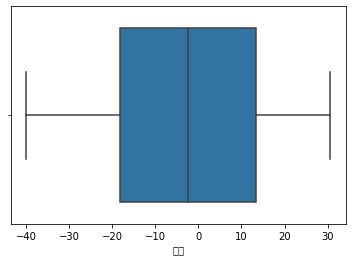

In [334]:
sns.boxplot(x = rwt_nor['기온'].unique())
plt.xlabel('기온')
plt.show()

# 노르웨이 최저기온은 영하 40도까지 내려간적 있으므로 오류값은 없는 것으로 판단

In [335]:
rwt_nor = pd.DataFrame(rwt_nor.groupby(['일시'])[['강수량','풍속','기온']].mean())

rwt_nor

,강수량,풍속,기온
일시,,,
2015-12-28,1.904762,5.264286,-3.103401
2016-01-04,0.664286,4.750000,-6.495031
2016-01-11,1.151724,5.583851,-3.889091
2016-01-18,0.934884,4.645714,-6.916477
2016-01-25,1.352174,4.857143,0.376437
...,...,...,...
2020-04-27,1.630233,3.590643,1.893296
2020-05-04,1.078571,4.689441,2.907101
2020-05-18,0.595455,3.433333,4.728346


In [336]:
rwt_nor.describe()

,강수량,풍속,기온
count,231.000000,231.000000,231.000000
mean,1.932161,4.742379,3.725899
std,1.208719,1.153567,6.116537
min,0.133333,2.719298,-8.041341
25%,1.070952,3.947098,-1.357529
50%,1.736364,4.691429,3.158427
75%,2.407143,5.366473,9.759586
max,7.274000,9.661111,17.711765


In [337]:
rwt_nor.isna().sum()

강수량    0
풍속     0
기온     0
dtype: int64

#### 베트남 Weather

In [338]:
rwt_vit = pd.DataFrame()

for i in [48914, 48808, 48870, 48877, 48845, 48840, 48887, 48917, 48820]:
    rwt_vit = rwt_vit.append(rwt[rwt['지점']==i])

rwt_vit = rwt_vit.sort_values(by=['지점명','일시'])

rwt_vit['국가'] = '베트남'

rwt_vit['일시'] = rwt_vit['일시'].str[:10] # 시간 부분 삭제

rwt_vit['일시'] = rwt_vit['일시'].astype('datetime64')

rwt_vit = rwt_vit.query('일시.dt.dayofweek == 0') # 일시를 일주일 간격으로 변환

rwt_vit # 베트남 풍속,강수량,기온

,지점,지점명,일시,풍속,강수량,기온,국가
122236,48914,까마우,2015-12-28,5.0,NaN,29.2,베트남
122237,48914,까마우,2015-12-28,5.0,NaN,30.6,베트남
122238,48914,까마우,2015-12-28,5.0,NaN,30.3,베트남
122239,48914,까마우,2015-12-28,2.0,NaN,28.2,베트남
122240,48914,까마우,2015-12-28,0.0,NaN,26.4,베트남
...,...,...,...,...,...,...,...
27303,48917,푸꾸옥,2021-08-16,0.0,NaN,27.2,베트남
27304,48917,푸꾸옥,2021-08-16,2.0,NaN,26.8,베트남
107856,48820,하노이,2016-12-12,2.0,NaN,28.0,베트남
107857,48820,하노이,2016-12-12,3.0,NaN,25.4,베트남


##### Preprocessing

In [339]:
rwt_vit['강수량'].isna().sum()

13788

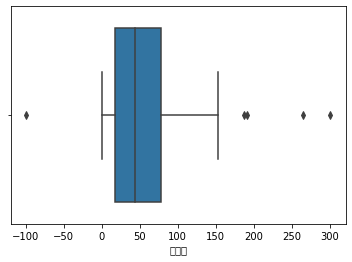

In [340]:
sns.boxplot(x = rwt_vit['강수량'].unique())
plt.xlabel('강수량')
plt.show()

# 음수인 이상치 제거 필요

In [341]:
rwt_vit[rwt_vit['강수량']<0]

,지점,지점명,일시,풍속,강수량,기온,국가
122518,48914,까마우,2016-02-01,2.0,-99.8,28.0,베트남
122625,48914,까마우,2016-02-15,1.0,-99.8,30.1,베트남
122626,48914,까마우,2016-02-15,3.0,-99.8,31.5,베트남
122627,48914,까마우,2016-02-15,3.0,-99.8,30.8,베트남
122628,48914,까마우,2016-02-15,3.0,-99.8,28.1,베트남
...,...,...,...,...,...,...,...
26181,48917,푸꾸옥,2021-02-22,5.0,-99.8,28.0,베트남
26182,48917,푸꾸옥,2021-02-22,3.0,-99.8,26.8,베트남
26183,48917,푸꾸옥,2021-02-22,0.0,-99.8,25.7,베트남
26184,48917,푸꾸옥,2021-02-22,2.0,-99.8,24.0,베트남


In [342]:
rwt_vit = rwt_vit[(rwt_vit['강수량']>=0) | (rwt_vit['강수량'].isna())] # 강수량 음수 제거

rwt_vit

,지점,지점명,일시,풍속,강수량,기온,국가
122236,48914,까마우,2015-12-28,5.0,NaN,29.2,베트남
122237,48914,까마우,2015-12-28,5.0,NaN,30.6,베트남
122238,48914,까마우,2015-12-28,5.0,NaN,30.3,베트남
122239,48914,까마우,2015-12-28,2.0,NaN,28.2,베트남
122240,48914,까마우,2015-12-28,0.0,NaN,26.4,베트남
...,...,...,...,...,...,...,...
27303,48917,푸꾸옥,2021-08-16,0.0,NaN,27.2,베트남
27304,48917,푸꾸옥,2021-08-16,2.0,NaN,26.8,베트남
107856,48820,하노이,2016-12-12,2.0,NaN,28.0,베트남
107857,48820,하노이,2016-12-12,3.0,NaN,25.4,베트남


In [343]:
rwt_vit['풍속'].isna().sum()

1

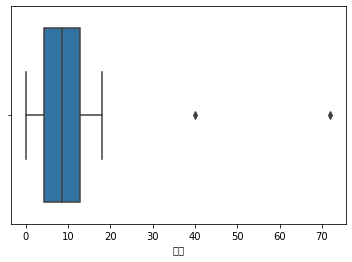

In [344]:
sns.boxplot(x = rwt_vit['풍속'].unique())
plt.xlabel('풍속')
plt.show()

In [345]:
rwt_vit['풍속'][rwt_vit['풍속']<0]

Series([], Name: 풍속, dtype: float64)

In [346]:
rwt_vit['기온'].isna().sum()

9

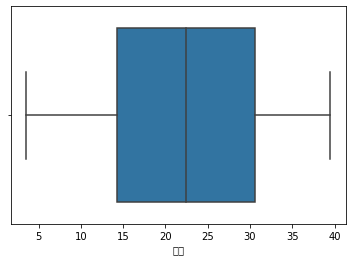

In [347]:
sns.boxplot(x = rwt_vit['기온'].unique())
plt.xlabel('기온')
plt.show()

# 이상치 없음.

In [348]:
rwt_vit2 = pd.DataFrame(rwt_vit.groupby(['일시']).mean()[['강수량','풍속','기온']])

rwt_vit2 = rwt_vit2[rwt_vit2.index<='2021-06-28']

rwt_vit2

,강수량,풍속,기온
일시,,,
2015-12-28,0.828571,2.375000,23.098214
2016-01-04,19.000000,1.666667,24.580328
2016-01-11,0.000000,2.015625,24.165625
2016-01-18,3.000000,1.822581,24.020968
2016-01-25,2.521429,3.250000,18.212500
...,...,...,...
2021-05-31,0.500000,2.156250,31.271875
2021-06-07,17.043750,2.078125,28.542188
2021-06-14,3.080000,2.234375,29.495313


In [349]:
rwt_vit2.describe()

,강수량,풍속,기온
count,273.000000,288.000000,288.000000
mean,7.190637,2.119864,26.465741
std,7.661904,0.414989,2.839870
min,0.000000,0.647059,17.800000
25%,1.000000,1.858817,24.403084
50%,4.736364,2.078125,26.842169
75%,10.554545,2.355932,28.883946
max,40.572222,3.546875,31.271875


In [350]:
rwt_vit2.isna().sum()

강수량    15
풍속      0
기온      0
dtype: int64

In [351]:
rwt_vit2[rwt_vit2['강수량'].isna()] # 해당 월 평균 강수량 데이터로 결측값 대치해보자! 

,강수량,풍속,기온
일시,,,
2016-02-08,NaN,2.355932,19.338596
2016-02-29,NaN,2.946429,22.907143
2017-02-06,NaN,2.343750,23.735938
2017-12-18,NaN,2.921875,20.045313
2018-02-05,NaN,3.125000,19.448437
2018-04-02,NaN,2.156250,25.909375
2018-04-09,NaN,2.269841,25.173016
2019-01-28,NaN,2.031250,23.398438
2019-02-04,NaN,2.609375,25.159375


In [352]:
rwt_vit2['일시'] = rwt_vit2.index
rwt_vit2['일시'] = rwt_vit2['일시'].astype('string')

rain_1602 = float(rwt_vit2[rwt_vit2['일시'].str.contains('2016-02')].mean()['강수량']) # 2016년 2월 강수량 평균
rain_1702 = float(rwt_vit2[rwt_vit2['일시'].str.contains('2017-02')].mean()['강수량']) # 2017년 2월 강수량 평균
rain_1712 = float(rwt_vit2[rwt_vit2['일시'].str.contains('2017-12')].mean()['강수량']) # 2017년 12월 강수량 평균
rain_1802 = float(rwt_vit2[rwt_vit2['일시'].str.contains('2018-02')].mean()['강수량']) # 2018년 2월 강수량 평균
rain_1804 = float(rwt_vit2[rwt_vit2['일시'].str.contains('2018-04')].mean()['강수량']) # 2018년 4월 강수량 평균
rain_1901 = float(rwt_vit2[rwt_vit2['일시'].str.contains('2019-01')].mean()['강수량']) # 2019년 1월 강수량 평균
rain_1902 = float(rwt_vit2[rwt_vit2['일시'].str.contains('2019-02')].mean()['강수량']) # 2019년 2월 강수량 평균
rain_1912 = float(rwt_vit2[rwt_vit2['일시'].str.contains('2019-12')].mean()['강수량']) # 2019년 12월 강수량 평균
rain_2003 = float(rwt_vit2[rwt_vit2['일시'].str.contains('2020-03')].mean()['강수량']) # 2020년 3월 강수량 평균
rain_2004 = float(rwt_vit2[rwt_vit2['일시'].str.contains('2020-04')].mean()['강수량']) # 2020년 4월 강수량 평균
rain_2102 = float(rwt_vit2[rwt_vit2['일시'].str.contains('2021-02')].mean()['강수량']) # 2021년 2월 강수량 평균
rain_2103 = float(rwt_vit2[rwt_vit2['일시'].str.contains('2021-03')].mean()['강수량']) # 2021년 3월 강수량 평균

In [353]:
rwt_vit2[rwt_vit2['일시'].str.contains('2016-02')]['강수량'].fillna(rain_1602) # 2016년 2월 강수량 평균으로 결측값 대치
rwt_vit2[rwt_vit2['일시'].str.contains('2017-02')]['강수량'].fillna(rain_1702) # 2017년 2월 강수량 평균으로 결측값 대치
rwt_vit2[rwt_vit2['일시'].str.contains('2017-12')]['강수량'].fillna(rain_1712) # 2017년 12월 강수량 평균으로 결측값 대치
rwt_vit2[rwt_vit2['일시'].str.contains('2018-02')]['강수량'].fillna(rain_1802) # 2018년 2월 강수량 평균으로 결측값 대치
rwt_vit2[rwt_vit2['일시'].str.contains('2018-04')]['강수량'].fillna(rain_1804) # 2018년 4월 강수량 평균으로 결측값 대치
rwt_vit2[rwt_vit2['일시'].str.contains('2019-01')]['강수량'].fillna(rain_1901) # 2019년 1월 강수량 평균으로 결측값 대치
rwt_vit2[rwt_vit2['일시'].str.contains('2019-02')]['강수량'].fillna(rain_1902) # 2019년 2월 강수량 평균으로 결측값 대치
rwt_vit2[rwt_vit2['일시'].str.contains('2019-12')]['강수량'].fillna(rain_1912) # 2019년 12월 강수량 평균으로 결측값 대치
rwt_vit2[rwt_vit2['일시'].str.contains('2020-03')]['강수량'].fillna(rain_2003) # 2020년 3월 강수량 평균으로 결측값 대치
rwt_vit2[rwt_vit2['일시'].str.contains('2020-04')]['강수량'].fillna(rain_2004) # 2020년 4월 강수량 평균으로 결측값 대치
rwt_vit2[rwt_vit2['일시'].str.contains('2021-02')]['강수량'].fillna(rain_2102) # 2021년 2월 강수량 평균으로 결측값 대치
rwt_vit2[rwt_vit2['일시'].str.contains('2021-03')]['강수량'].fillna(rain_2103) # 2021년 3월 강수량 평균으로 결측값 대치

rwt_vit2.isna().sum()

강수량    15
풍속      0
기온      0
일시      0
dtype: int64

#### 중국 Weather

In [310]:
data = pd.read_csv("/content/drive/MyDrive/빅콘/Seafood_Import_Price_Prediction/DATA/weather/rwt_china_raw.csv",encoding='cp949')

data

,Unnamed: 0,지점,지점명,일시,풍속,강수량,기온
0,127994,50527,하일라르,2015-12-28 03:00,2.0,NaN,-28.8
1,127995,50527,하일라르,2015-12-28 06:00,2.0,NaN,-24.2
2,127996,50527,하일라르,2015-12-28 09:00,4.0,NaN,-26.6
3,127997,50527,하일라르,2015-12-28 12:00,3.0,NaN,-25.3
4,127998,50527,하일라르,2015-12-28 15:00,6.0,NaN,-29.5
...,...,...,...,...,...,...,...
1115542,106881,59981,시사다오,2021-08-17 12:00,1.0,NaN,28.8
1115543,106882,59981,시사다오,2021-08-17 15:00,1.0,NaN,28.3
1115544,106883,59981,시사다오,2021-08-17 18:00,0.0,NaN,27.6
1115545,106884,59981,시사다오,2021-08-17 21:00,2.0,NaN,27.8


In [311]:
data['일시'] = data['일시'].astype('string')

data['일시'] = data['일시'].str[:10]

data['일시'] = data['일시'].astype('datetime64')

data = data.query('일시.dt.dayofweek == 0')

data['국가'] = '중국'

data # 중국 일주일간 rwt 데이터

,Unnamed: 0,지점,지점명,일시,풍속,강수량,기온,국가
0,127994,50527,하일라르,2015-12-28,2.0,NaN,-28.8,중국
1,127995,50527,하일라르,2015-12-28,2.0,NaN,-24.2,중국
2,127996,50527,하일라르,2015-12-28,4.0,NaN,-26.6,중국
3,127997,50527,하일라르,2015-12-28,3.0,NaN,-25.3,중국
4,127998,50527,하일라르,2015-12-28,6.0,NaN,-29.5,중국
...,...,...,...,...,...,...,...,...
1115533,106872,59981,시사다오,2021-08-16,2.0,NaN,31.4,중국
1115534,106873,59981,시사다오,2021-08-16,1.0,NaN,29.0,중국
1115535,106874,59981,시사다오,2021-08-16,3.0,NaN,28.5,중국
1115536,106875,59981,시사다오,2021-08-16,1.0,NaN,27.8,중국


In [312]:
data = data[data['일시']<='2021-06-28']

data = data.iloc[:,1:]

data

,지점,지점명,일시,풍속,강수량,기온,국가
0,50527,하일라르,2015-12-28,2.0,NaN,-28.8,중국
1,50527,하일라르,2015-12-28,2.0,NaN,-24.2,중국
2,50527,하일라르,2015-12-28,4.0,NaN,-26.6,중국
3,50527,하일라르,2015-12-28,3.0,NaN,-25.3,중국
4,50527,하일라르,2015-12-28,6.0,NaN,-29.5,중국
...,...,...,...,...,...,...,...
1115148,59981,시사다오,2021-06-28,7.0,NaN,30.8,중국
1115149,59981,시사다오,2021-06-28,4.0,NaN,29.5,중국
1115150,59981,시사다오,2021-06-28,3.0,NaN,29.2,중국
1115151,59981,시사다오,2021-06-28,6.0,NaN,29.2,중국


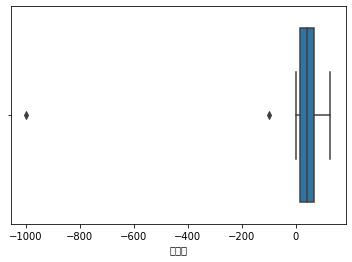

In [313]:
sns.boxplot(data['강수량'].unique())
plt.xlabel('강수량')
plt.show()

In [314]:
data[data['강수량']<0] # 2% 비율이고 값을 알 수 없으므로 drop하기

,지점,지점명,일시,풍속,강수량,기온,국가
389,50527,하일라르,2016-02-15,3.0,-99.8,-16.6,중국
391,50527,하일라르,2016-02-15,4.0,-99.8,-14.5,중국
393,50527,하일라르,2016-02-15,5.0,-99.8,-19.1,중국
394,50527,하일라르,2016-02-15,3.0,-99.8,-18.0,중국
395,50527,하일라르,2016-02-15,3.0,-99.8,-18.2,중국
...,...,...,...,...,...,...,...
1100479,58027,쉬저우,2021-02-08,3.0,-999.0,1.6,중국
1101579,58238,난징,2021-04-19,5.0,-999.0,14.9,중국
1105478,58666,다천다오,2021-02-08,10.0,-999.0,7.3,중국
1113583,59948,야샨,2021-02-08,8.0,-999.0,19.2,중국


In [315]:
data = data[(data['강수량']>=0) | (data['강수량'].isna())] # 강수량 음수 제거

data

,지점,지점명,일시,풍속,강수량,기온,국가
0,50527,하일라르,2015-12-28,2.0,NaN,-28.8,중국
1,50527,하일라르,2015-12-28,2.0,NaN,-24.2,중국
2,50527,하일라르,2015-12-28,4.0,NaN,-26.6,중국
3,50527,하일라르,2015-12-28,3.0,NaN,-25.3,중국
4,50527,하일라르,2015-12-28,6.0,NaN,-29.5,중국
...,...,...,...,...,...,...,...
1115148,59981,시사다오,2021-06-28,7.0,NaN,30.8,중국
1115149,59981,시사다오,2021-06-28,4.0,NaN,29.5,중국
1115150,59981,시사다오,2021-06-28,3.0,NaN,29.2,중국
1115151,59981,시사다오,2021-06-28,6.0,NaN,29.2,중국


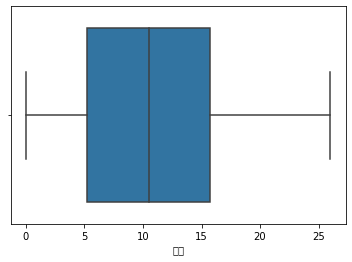

In [316]:
sns.boxplot(data['풍속'].unique())
plt.xlabel('풍속')
plt.show()

# 이상치 없음.

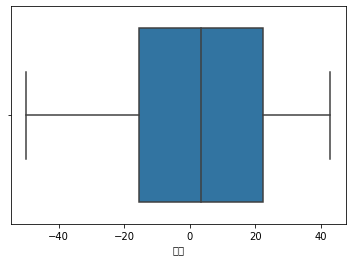

In [317]:
sns.boxplot(data['기온'].unique())
plt.xlabel('기온')
plt.show()

# 이상치 없음.

In [318]:
chn_rwt = pd.DataFrame(data.groupby('일시').mean())

chn_rwt = chn_rwt[['풍속','강수량','기온']]

chn_rwt

,풍속,강수량,기온
일시,,,
2015-12-28,2.338129,0.708333,-0.262050
2016-01-04,2.358491,2.372093,0.026772
2016-01-11,2.552050,1.794366,-2.603943
2016-01-18,2.481132,1.052778,-3.982704
2016-01-25,2.214173,0.525000,-6.559213
...,...,...,...
2021-05-31,2.718799,5.530818,20.851501
2021-06-07,2.575277,6.135652,22.328051
2021-06-14,2.808847,6.745064,22.666352


In [319]:
chn_rwt.describe()

,풍속,강수량,기온
count,288.000000,287.000000,288.000000
mean,2.441163,3.006765,12.015510
std,0.286882,2.139905,9.517001
min,1.771739,0.033333,-6.559213
25%,2.250591,1.510653,3.128850
50%,2.406681,2.604167,13.320644
75%,2.593325,4.041554,21.004752
max,4.026316,12.142105,26.110147


In [320]:
chn_rwt.isna().sum()

풍속     0
강수량    1
기온     0
dtype: int64

In [321]:
chn_rwt['일시'] = chn_rwt.index

chn_rwt

,풍속,강수량,기온,일시
일시,,,,
2015-12-28,2.338129,0.708333,-0.262050,2015-12-28
2016-01-04,2.358491,2.372093,0.026772,2016-01-04
2016-01-11,2.552050,1.794366,-2.603943,2016-01-11
2016-01-18,2.481132,1.052778,-3.982704,2016-01-18
2016-01-25,2.214173,0.525000,-6.559213,2016-01-25
...,...,...,...,...
2021-05-31,2.718799,5.530818,20.851501,2021-05-31
2021-06-07,2.575277,6.135652,22.328051,2021-06-07
2021-06-14,2.808847,6.745064,22.666352,2021-06-14


In [322]:
chn_rwt['일시'] = chn_rwt['일시'].astype('string')

rain_2102 = chn_rwt[chn_rwt['일시'].str.contains('2021-02')].mean()['강수량'] # 2021년 2월 강수량 평균으로 결측값 대치

chn_rwt = chn_rwt.fillna(rain_2102)

chn_rwt.isna().sum()

풍속     0
강수량    0
기온     0
일시     0
dtype: int64

In [323]:
chn_rwt.drop('일시',axis=1,inplace=True)

chn_rwt

,풍속,강수량,기온
일시,,,
2015-12-28,2.338129,0.708333,-0.262050
2016-01-04,2.358491,2.372093,0.026772
2016-01-11,2.552050,1.794366,-2.603943
2016-01-18,2.481132,1.052778,-3.982704
2016-01-25,2.214173,0.525000,-6.559213
...,...,...,...
2021-05-31,2.718799,5.530818,20.851501
2021-06-07,2.575277,6.135652,22.328051
2021-06-14,2.808847,6.745064,22.666352


## Add to Training Data

In [ ]:
df_train = pd.merge(df_train, df_weather, how='left', on=['year', 'month', 'day', 'CTRY_1'])

In [ ]:
pd.set_option("display.max_columns", None)
df_train.sample(5)

---

# Salinity

## Import Data

In [ ]:
# df_salinity = pd.read_csv(os.path.join(root, 'raw_salinity.csv'))

## Drop Columns & Rows

In [ ]:
# df_salinity.drop(df_salinity.columns[2], inplace=True, axis=1)
# df_salinity = df_salinity[(2015 <= df_salinity['obs_year']) & (df_salinity['obs_year'] <= 2021)]

2020, 2021 데이터의 부재로 인해 보류

---

# Oil

## Import Data

In [ ]:
df_oil = pd.read_csv(os.path.join(root, 'raw_oil.csv'))
df_oil_dubai = pd.read_csv(os.path.join(root, 'raw_oil_dubai.csv'))
df_oil_brent = pd.read_csv(os.path.join(root, 'raw_oil_brent.csv'))

## Preprocess

In [ ]:
def preprocess_oil(df):
    df['year'] = df['날짜'].str[:4].astype('int')
    df['month'] = df['날짜'].str[6:8].astype('int')
    df['day'] = df['날짜'].str[10:12].astype('int')
#     df['date'] = pd.to_datetime(df['날짜'].str[:4] + df['날짜'].str[6:8] + df['날짜'].str[10:12])
#     df = df.query('date.dt.dayofweek == 0')
    df.drop(columns = ['날짜', '오픈', '고가', '저가', '거래량', '변동 %'], inplace=True, axis=1)
    df.sort_index(ascending=False)
    return df

In [ ]:
df_oil = preprocess_oil(df_oil)
df_oil_dubai = preprocess_oil(df_oil_dubai)
df_oil_brent = preprocess_oil(df_oil_brent)

## Check

In [ ]:
print("oil:", len(df_oil), "\ndubai:", len(df_oil_dubai), "\nbrent:", len(df_oil_brent))

oil과 비교하였을 때 dubai의 경우 28개, brent의 경우 3개의 데이터가 적다  
따라서 df_oil 데이터를 사용하도록 한다

## Add to Training Data

In [ ]:
df_train = pd.merge(df_train, df_oil, how='left', on=['year', 'month', 'day'])

In [ ]:
pd.set_option("display.max_columns", None)
df_train.sample(5)

---

# Korea Weather

## Import Data

In [ ]:
df_weather_kr = pd.read_csv(os.path.join(root, 'raw_weather_korea.csv'), encoding='euc-kr')

## Group
일자 별로 평균 구하기

In [ ]:
df_weather_kr['wind_kr'] = df_weather_kr[['일시', '평균 풍속(m/s)']].groupby(['일시']).transform('mean')
df_weather_kr['temperature_kr'] = df_weather_kr[['일시', '평균 기온(°C)']].groupby(['일시']).transform('mean')
df_weather_kr['water_temp_kr'] = df_weather_kr[['일시', '평균 수온(°C)']].groupby(['일시']).transform('mean')

## Preprocess Date

In [ ]:
df_weather_kr['year'] = df_weather_kr['일시'].str[:4].astype('int')
df_weather_kr['month'] = df_weather_kr['일시'].str[5:7].astype('int')
df_weather_kr['day'] = df_weather_kr['일시'].str[8:].astype('int')

## Drop Column
어차피 전부 해안가 대한민국이라 지점은 필요없다  
사용한 컬럼은 제거한다

In [ ]:
drop = ['지점', '일시', '평균 풍속(m/s)', '평균 기온(°C)', '평균 수온(°C)']

In [ ]:
df_weather_kr.drop(columns=drop, inplace=True, axis=1)

## Add to Training Data

In [ ]:
df_train = pd.merge(df_train, df_weather_kr, how='left', on=['year', 'month', 'day'])

In [ ]:
pd.set_option("display.max_columns", None)
df_train.sample(5)

---

# 소비자물가지수

## Import Data

In [ ]:
cpi_purpose = pd.read_csv("/content/drive/MyDrive/빅콘/Seafood_Import_Price_Prediction/DATA/cpi/raw_cpi_purpose.csv",encoding='cp949')  # CPI

cpi_purpose

## 소비자물가 총지수

### Drop Columns/Rows

In [ ]:
cpi_purpose.drop('시도별',axis=1,inplace=True)

cpi_purpose_copy = cpi_purpose.copy()

cpi_purpose_copy.drop('지출목적별',axis=1,inplace=True)

cpi_total = cpi_purpose_copy.iloc[0,:] # 전국 소비자물가 총지수만 추출

cpi_total = pd.DataFrame(cpi_total.values,columns=['cpi'],index=cpi_total.index)

cpi_total

### Pivoting

In [ ]:
cpi_purpose_copy = cpi_purpose.copy()

cpi_purpose_copy.drop('지출목적별',axis=1,inplace=True)

cpi_total = cpi_purpose_copy.iloc[0,:] # 전국 소비자물가 총지수만 추출

cpi_total = pd.DataFrame(cpi_total.values,columns=['cpi'],index=cpi_total.index)

cpi_total

## 지출목적별 소비자물가지수

In [354]:
cpi_purpose2 = cpi_purpose.iloc[[1,11],:]

cpi_purpose2 # 전국 식료품별, 음식서비스별 cpi만 추출

,지출목적별,2015. 12,2016. 01,2016. 02,2016. 03,2016. 04,2016. 05,2016. 06,2016. 07,2016. 08,2016. 09,2016. 10,2016. 11,2016. 12,2017. 01,2017. 02,2017. 03,2017. 04,2017. 05,2017. 06,2017. 07,2017. 08,2017. 09,2017. 10,2017. 11,2017. 12,2018. 01,2018. 02,2018. 03,2018. 04,2018. 05,2018. 06,2018. 07,2018. 08,2018. 09,2018. 10,2018. 11,2018. 12,2019. 01,2019. 02,2019. 03,2019. 04,2019. 05,2019. 06,2019. 07,2019. 08,2019. 09,2019. 10,2019. 11,2019. 12,2020. 01,2020. 02,2020. 03,2020. 04,2020. 05,2020. 06,2020. 07,2020. 08,2020. 09,2020. 10,2020. 11,2020. 12,2021. 01,2021. 02,2021. 03,2021. 04,2021. 05,2021. 06
1,01 식료품 · 비주류음료,99.95,100.76,103.43,102.25,102.30,101.24,99.66,99.65,101.02,105.94,104.48,102.93,104.02,107.16,107.26,106.32,105.19,104.85,104.09,104.39,107.5,108.84,106.16,103.20,104.44,106.00,109.07,107.32,107.86,106.85,105.48,105.80,111.34,115.20,112.16,108.67,108.86,108.8,109.54,108.48,109.4,108.83,107.64,106.68,107.70,110.52,110.74,107.89,109.01,110.81,110.27,111.26,111.29,111.48,111.18,111.28,114.78,119.68,119.82,115.35,115.79,118.04,120.97,120.61,120.34,119.70,118.43
11,11 음식 및 숙박,101.06,101.40,101.67,101.98,102.26,102.40,102.50,102.74,102.91,102.92,103.02,103.07,103.27,103.75,104.02,104.31,104.49,104.80,104.87,105.20,105.5,105.36,105.57,105.67,106.07,106.55,106.94,107.29,107.70,108.07,108.17,108.52,108.76,108.58,108.74,108.96,109.35,109.7,109.89,109.63,109.8,110.01,110.11,110.35,110.64,110.09,110.27,110.29,110.45,110.97,110.93,110.82,110.90,110.86,110.95,111.13,111.35,111.25,111.51,111.41,111.67,111.96,112.26,112.42,112.93,113.11,113.37


In [355]:
cpi_purpose3 = pd.DataFrame(cpi_purpose2.iloc[0,:].values,index = cpi_purpose2.columns,columns=['식료품 cpi'])

cpi_purpose3['음식 및 숙박 cpi'] = cpi_purpose2.iloc[1,:].values

cpi_purpose3.drop('지출목적별',axis=0,inplace=True) # 지출목적별 행 삭제

cpi_purpose3 # 식료품, 음식 cpi

,식료품 cpi,음식 및 숙박 cpi
2015. 12,99.95,101.06
2016. 01,100.76,101.4
2016. 02,103.43,101.67
2016. 03,102.25,101.98
2016. 04,102.3,102.26
...,...,...
2021. 02,120.97,112.26
2021. 03,120.61,112.42
2021. 04,120.34,112.93
2021. 05,119.7,113.11


## Preprocess Date

In [ ]:
cpi_total.reset_index(inplace=True)  # 날짜 인덱스 > 컬럼으로 변경
cpi_purpose3.reset_index(inplace=True)  # 날짜 인덱스 > 컬럼으로 변경

In [ ]:
cpi_total['year'] = cpi_total['index'].str[:4].astype('int')
cpi_total['month'] = cpi_total['index'].str[5:].astype('int')
cpi_total.drop(columns=['index'], inplace=True, axis=1)

cpi_purpose3['year'] = cpi_purpose3['index'].str[:4].astype('int')
cpi_purpose3['month'] = cpi_purpose3['index'].str[5:].astype('int')
cpi_purpose3.drop(columns=['index'], inplace=True, axis=1)

## Add to Training Data

In [ ]:
df_train = pd.merge(df_train, df_cpi1, how='left', on=['year', 'month'])
df_train = pd.merge(df_train, df_cpi2, how='left', on=['year', 'month'])

In [ ]:
pd.set_option("display.max_columns", None)
df_train.sample(5)

---

# Final

## One-hot Encoding

In [ ]:
one_hot = ['CTRY_1', 'CTRY_2', 'P_PURPOSE', 'CATEGORY_1', 'CATEGORY_2', 'P_NAME']

In [ ]:
df_train = pd.get_dummies(df_train, columns=one_hot)

## Drop Columns

In [ ]:
drop = ['REG_DATE', 'P_TYPE', 'P_IMPORT_TYPE']

In [ ]:
df_train.drop(columns = drop, inplace=True)

In [ ]:
pd.set_option("display.max_columns", None)
df_train.sample(5)

## Save Files

In [ ]:
def save_file(df, file_name):
    df.to_csv(os.path.join(root, file_name), encoding='utf-8')

In [ ]:
save_file(df_weather, 'preprocessed_weather.csv')  # 제조국 날씨
save_file(df_oil, 'preprocessed_oil.csv')  # 원유 종가
save_file(df_weather_kr, 'preprocessed_weather_korea.csv')  # 한국 날씨
save_file(df_cpi1, 'preprocessed_cpi_region.csv')  # 전체 소비자물가지수
save_file(df_cpi2, 'preprocessed_cpi_purpose.csv')  # 음식/음식서비스 소비자물가지수
save_file(df_train, 'preprocessed_train.csv')  # 최종 df